如果是在一个金属表面吸附一个原子，一个原子在表面上有两个自由度，在金属表面上构成一个能量曲面。
如果是在表面吸附一个多原子分子，由于每个原子都有自由度，将会有更高维度的能量曲面。
我们的目标是通过训练模型及其能量，知悉整个高维能量曲面。

In [162]:
from ase.build import bulk
from ase.optimize import LBFGS
from ase.calculators.emt import EMT
from ase.visualize import view
from ase.io import write, read, lammpsdata
from ase.build import fcc100, add_adsorbate, molecule, fcc111
from ase.constraints import FixAtoms, FixCartesian
from ase.atoms import Atoms
from lammps import lammps
from ase.visualize.plot import plot_atoms

import matplotlib.pyplot as plt
import os
import numpy as np
import lammps
import pandas


Function part

In [163]:
def compare_class(ini_atoms, pre_atoms):
    same = True
    for key, value in vars(ini_atoms).items():
        model_value = vars(pre_atoms).get(key)
        if isinstance(value != model_value, bool):
            # 如果是布尔值，需要使用相应的操作符进行比较
            if value != model_value:
                same = False
                print('\n', key)
                print(vars(ini_atoms)[key])
                print(vars(pre_atoms)[key])
        elif (value != model_value).all():  # 如果两个实例相同属性不相等
                same = False  # 则说明 atoms 和 model 不相同
                print('\n', key)
                print(vars(ini_atoms)[key])
                print(vars(pre_atoms)[key])
    return( same )

In [164]:
def cal_strain(ini_atoms, pre_atoms):
    # 函数用于计算应变，变形前模型：ini_atoms, 变形后模型：pre_atoms，两个模型的属性是 ase.atoms.Atoms，
    # 如果两个模型不是Atoms(Type Error)，或者不具有应变变换(Value Error)，会提示错误。

    isAtoms = isinstance(ini_atoms, Atoms) + isinstance(pre_atoms, Atoms)
    len_queal= len(ini_atoms.positions) == len(pre_atoms.positions)
    if isAtoms*len_queal == 0:
        print('Two model are Atoms:', isAtoms==2)
        print('Two models with equal atomic numbers :', len_queal==1)
        raise TypeError("Model should be Atoms")
    ini_cor = ini_atoms.cell.array
    pre_cor = pre_atoms.cell.array
    # ini_cor = np.concatenate((ini_atoms.cell.array, ini_atoms.positions), axis=0)  # 盒子和原子都统一至坐标 
    # pre_cor = np.concatenate((pre_atoms.cell.array, pre_atoms.positions), axis=0)
    np.seterr(divide='ignore', invalid='ignore')  # 忽略警告，因为坐标值有0值做除数
    strains = pre_cor / ini_cor  # 坐标相除，获得比例

    strains = np.array(strains) # 转换为 numpy 数组，以便使用 numpy 的函数
    max_values = np.nanmax(strains, axis=0) # 按列计算最大值，忽略 NaN 值
    nan_mask = np.isnan(strains) # 找出所有的 NaN 值
    strains[nan_mask] = np.take(max_values, np.where(nan_mask)[1]) # 替换 NaN 值为对应列的最大值
    strains.tolist() # 转换回 Python 列表并返回

    strain_list = np.full(3, np.nan)
    for column in range(3):  # 检查每一列是否都具有相同的应变
        strains_column = strains[:,column]
        strain_equal = all( abs(x-strains_column[0])<1E-3  for x in strains_column)
        if strain_equal ==1:
            strain_list[column] = strains_column[0]
        else:
            print(strains_column)
            raise ValueError("Strain are not uniform")
    strain_list = strain_list-1
    print('strain: ',strain_list )
    return(strain_list)

In [165]:
def cal_LBFGC(ini_model, potential = EMT, fmax=1E-6, steps=1000):
    # 执行动力学过程，默认的势函数是EMT，力收敛判断值1E-6，最大动力学步数1E3
    # 这个优化似乎不能放缩盒子
    ini_model.set_calculator(potential()) # setting the calculated potential 
    # 创建 LBFGS 实例
    dyn = LBFGS(ini_model)
    # 进行能量最小化优化计算
    dyn.run(fmax, steps)

    # 输出优化后的结构信息和能量值
    opt_config = dyn.atoms # initial model
    opt_energy = dyn.atoms.get_potential_energy()
    print('Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm')
    return(opt_config, opt_energy)

In [166]:
def set_strain(ini_model, strain=[0,0,0], is_opt=True):
    # strain 表面应变由三个值控制 [ε1 ε2 ε6]
    isAtoms = isinstance(ini_model, Atoms)
    if isAtoms == 0:
        raise TypeError("Model should be Atoms")
    
    strain_slab = ini_model.copy()
    # 获取当前的晶格矩阵, 复制初始无应变构型
    cell = strain_slab.get_cell()

    strains = np.array([[strain[0], strain[2]],
               [strain[2], strain[1]]])
    deform = strains + np.identity(2)
    cell[:2,:2] = np.dot(cell[:2,:2], deform) 
    # 将新的晶格矩阵赋值给 原始 Cu 对象 
    strain_slab.set_cell(cell, scale_atoms=True, apply_constraint=False)  # scale_Atoms=True must be set to True to ensure that ...
    
    # ...the atomic coordinates adapt to changes in the lattice matrix
    
    if is_opt==True:
        opt_strain_slab, opt_strain_energr = cal_LBFGC(strain_slab)
    else:
        opt_strain_slab, opt_strain_energr = strain_slab, False
    # strain = compare_atoms(ini_model,strain_slab)
    return(opt_strain_slab, opt_strain_energr)

In [192]:
def plot_model(model):
    # 绘制model构型的三视图
    fig, axs = plt.subplots(1, 3, dpi=600)
    fig.subplots_adjust(wspace=0.4, hspace=0)

    # 绘制第一个子图（俯视图）
    # print(adslab.cell)
    axs[0].set_aspect('equal')
    cell = model.get_cell()
    plot_atoms(model, axs[0], radii=0.8, rotation=('0x,0y,0z')) # the "rotation" value is the  rotation angle of the axis
    axs[0].set_xlim(-1, cell[0,0]+cell[1,0]+2)
    axs[0].set_ylim(-1, cell[1,1]+4)
    axs[0].set_title('Top view', fontsize=10)
    # axs[0].quiver(0.8, 0, 0.2, 0, color='r')

    # 绘制第二个子图（侧视图）
    axs[1].set_aspect('equal')
    plot_atoms(model, axs[1], radii=0.8, rotation=('-90x,0y,0z'))
    axs[1].set_xlim(-1, cell[0,0]+cell[1,0]+3)
    axs[1].set_ylim(-1, cell[2,2]+3)
    axs[1].set_title('Front view', fontsize=10)
    
    # 绘制第个子图（侧视图）
    axs[2].set_aspect('equal')
    plot_atoms(model, axs[2], radii=0.8, rotation=('-90x,90y,0z'))
    axs[2].set_xlim(-4, cell[0,0]+cell[1,0])
    axs[2].set_ylim(-1, cell[2,2]+3)
    axs[2].set_title('Side view', fontsize=10)
    plt.show()
    print('plot end')

In [168]:
def opt_strain(strain,bulk):
    # 在bulk上施加应变
    strain_bulk = bulk.copy()
    # 获取当前的晶格矩阵, 复制初始无应变构型
    cell = strain_bulk.get_cell()
    nostrain = np.identity(3) # 单位矩阵
    # 在 x 方向上添加应变
    # strain = [0.1, 0, 0]
    strains = nostrain + np.array([[strain[0], strain[2], 0 ],
                                [strain[2], strain[1], 0],
                                [0, 0, 0]])
    newcell = np.array(cell) @ strains  #此处为矩阵相乘
    # 将新的晶格矩阵赋值给 原始 Cu 对象 
    strain_bulk.set_cell(newcell, scale_atoms=True)  # scale_Atoms=True must be set to True to ensure that ...
    # ...the atomic coordinates adapt to changes in the lattice matrix
    strain = cal_strain(bulk,strain_bulk)
    print(strain)
    
    # 施加应变后的模型，lammps可读文件
    write('strain.lmp', strain_bulk, format='lammps-data')
    
    # 执行lammps优化，固定了x和y的自由度，只放松了z方向的自由度
    infile = 'in.strain.in'
    lmp = lammps(cmdargs=['-log', 'none'])
    lmp.file(infile)

    atoms = lammpsdata.read_lammps_data('opt_strain.data',style='atomic')
    strain_bulk.set_cell(atoms.get_cell(), scale_atoms=True)
    strain_real = cal_strain(bulk,strain_bulk)
    return(strain_bulk, strain_real)

1. Initial cofiguration of Cu bulk

In [169]:
model = fcc111("Cu", size=(3, 3, 3),periodic=True)
# cons= FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
# adslab.set_constraint(cons)
# adslab.center(vacuum=13.0, axis=2)
model.set_pbc(True) # 最早的初始构型
# adslab.set_calculator(EMT()) # setting the calculated potential 
# print(adslab.positions[:,0])
# print(type(adslab))
opt_config, opt_energe= cal_LBFGC(model)  # LBFGC 优化，实际上由于盒子不能放缩，所以无变化
print('\n inipotential = ', opt_energe, '\n')
strain = cal_strain(model,model)
write('bulk.lmp', model, format='lammps-data')  # 输出bulk，提供给lammps优化

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 16:29:40       -0.153401*       0.0000
Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm

 inipotential =  -0.15340080668105394 

strain:  [0. 0. 0.]


In [170]:
# lammps优化，输出 opt_model.data
infile = 'in.relax.in'
from lammps import lammps
lmp = lammps()
lmp.file(infile)

LAMMPS (28 Mar 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Total wall time: 0:36:41
Reading data file ...
  triclinic box = (0 0 0) to (7.6579664 6.6319935 6.2527034) with tilt (3.8289832 0 0)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  27 atoms
  read_data CPU = 0.014 seconds
Reading eam/alloy potential file Cu_zhou.eam.alloy with DATE: 2007-10-12
Switching to 'neigh_modify every 1 delay 0 check yes' setting during minimization
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11.0375
  ghost atom cutoff = 11.0375
  binsize = 5.51875, bins = 3 2 2
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up cg style mi

In [171]:
# 读取 opt_model.data
atoms = lammpsdata.read_lammps_data('opt_model.data',style='atomic')
# atoms.set_pbc(True)
strain = cal_strain(model,atoms)
bulk = opt_config.copy()
bulk.set_cell(atoms.get_cell(), scale_atoms=True)  
# 把lammps优化后的盒子赋值给bulk，得到bulk模型
srtain = cal_strain(model,bulk) # 优化后的构型相对变化
# print(bulk.get_cell())

strain:  [0.00170449 0.00170449 0.00170449]
strain:  [0.00170449 0.00170449 0.00170449]



2. Set strain for bulk

x and y axis are fixed, z axis is relaxed


In [172]:
strain = [0.1, 0, 0]
strain_bulk, strain_real = opt_strain(strain,bulk)

strain:  [0.1 0.  0. ]
[0.1 0.  0. ]
LAMMPS (28 Mar 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Reading data file ...
  triclinic box = (0 0 0) to (8.4381213 6.6432977 6.2633611) with tilt (4.2190607 0 0)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  27 atoms
  read_data CPU = 0.000 seconds
Reading eam/alloy potential file Cu_zhou.eam.alloy with DATE: 2007-10-12
Switching to 'neigh_modify every 1 delay 0 check yes' setting during minimization
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11.0375
  ghost atom cutoff = 11.0375
  binsize = 5.51875, bins = 3 2 2
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up

In [173]:
cal_strain(bulk,strain_bulk)

strain:  [ 0.1         0.         -0.03929709]


array([ 0.1       ,  0.        , -0.03929709])


3. Creat slab


In [233]:
adslab = strain_bulk.copy()
# 这里的tags与ase创建的构型的tags属性不同，ase创建的构型变量，tags属性与构型的分层相关
# tag all slab atoms below surface as 0, surface as 1, adsorbate as 2
tags = np.zeros(len(adslab)) # 除了表面层的原子
tags[18:27] = 1 # 被吸附基底的表面层
# tags[27:] = 2  # 11个原子，刚好是吸附分子

adslab.set_tags(tags) # 将tags属性替换

# Fixed atoms are prevented from moving during a structure relaxation. We fix all slab atoms beneath the surface
cons= FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
adslab.set_constraint(cons) # 施加约束
adslab.center(vacuum=5.0, axis=2)
plot_model(adslab)
print(adslab.positions)
adslab, adslab_e = cal_LBFGC(adslab)
plot_model(adslab)
print(adslab.positions)

KeyboardInterrupt: 


3. Adsorbed molecule



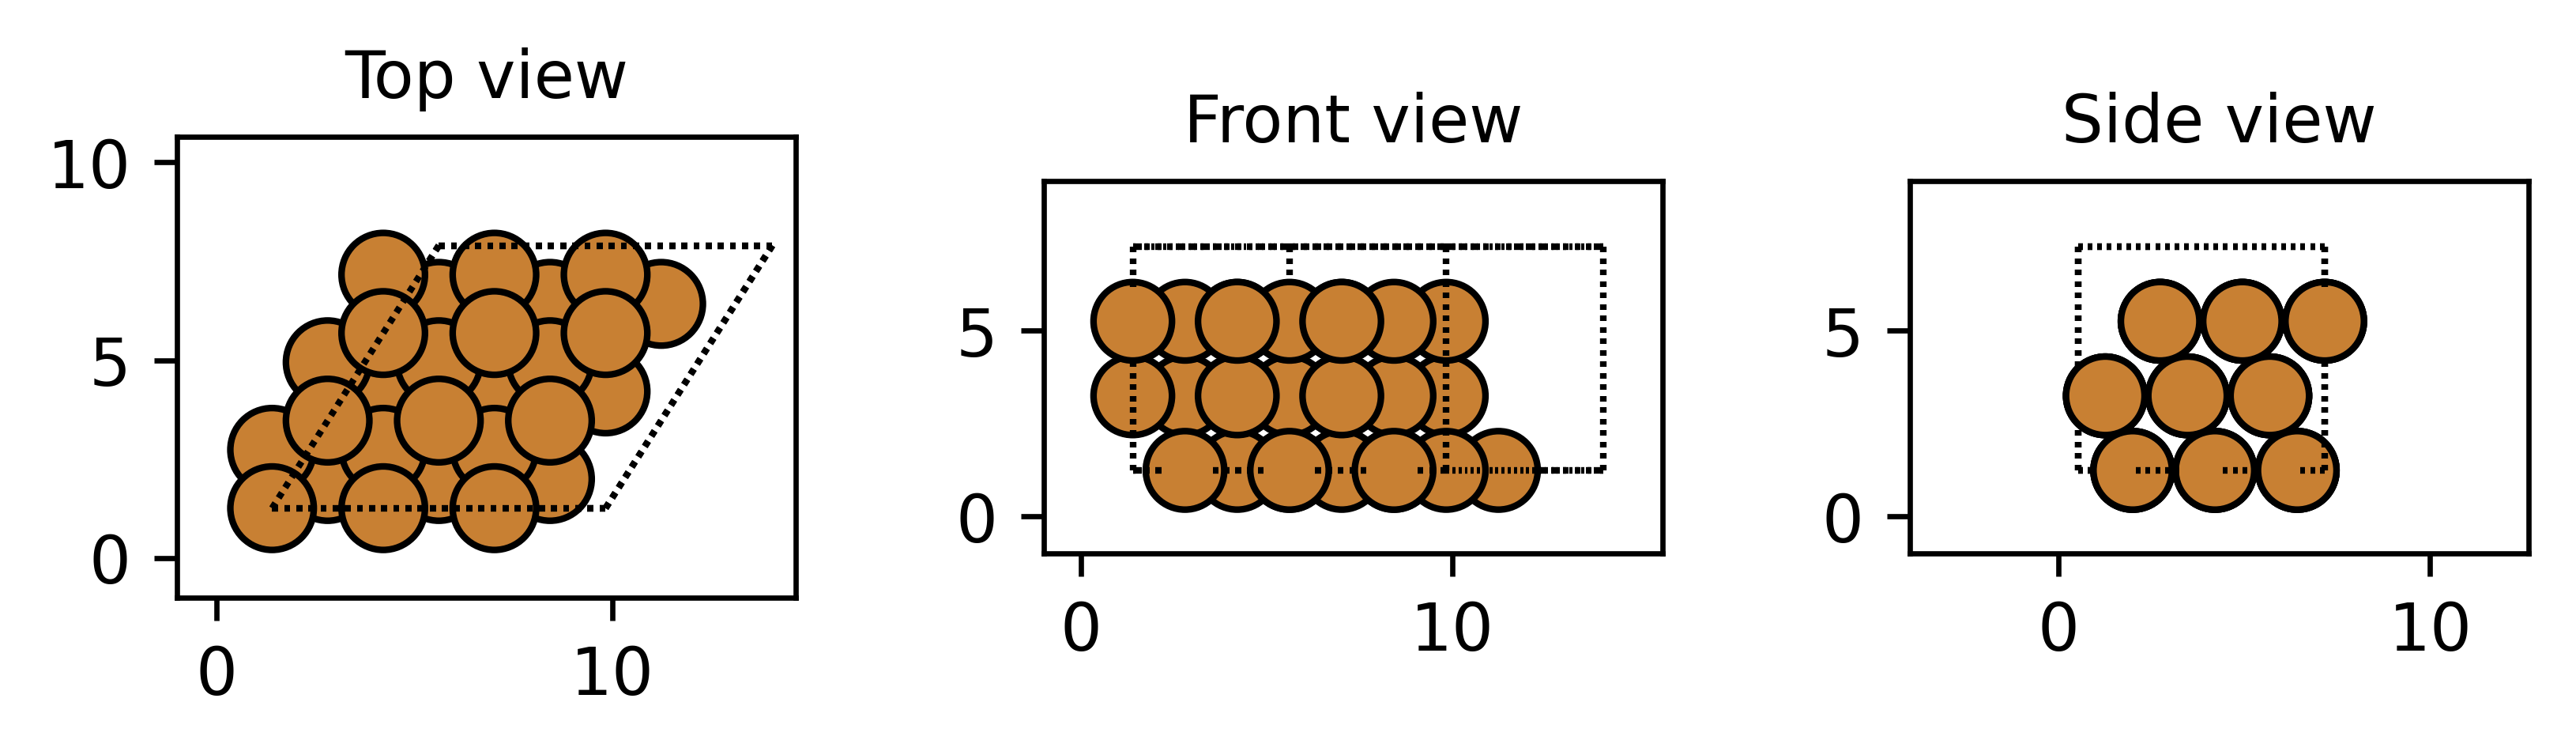

plot end


In [207]:
tags = strain_bulk.get_tags()
cell = strain_bulk.get_cell()
positions = strain_bulk.positions
plot_model(strain_bulk)

In [226]:
top = positions[tags==1][:,:2]
pla_cell = cell
print(pla_cell)
rel_top = np.array(list(map(lambda v: np.linalg.solve(cell, v), top)))
rel_top


Cell([[8.438121322723608, 0.0, 0.0], [4.219060661361802, 6.6432976597216395, 0.0], [0.0, 0.0, 6.017229222999999]])


ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 2 is different from 3)

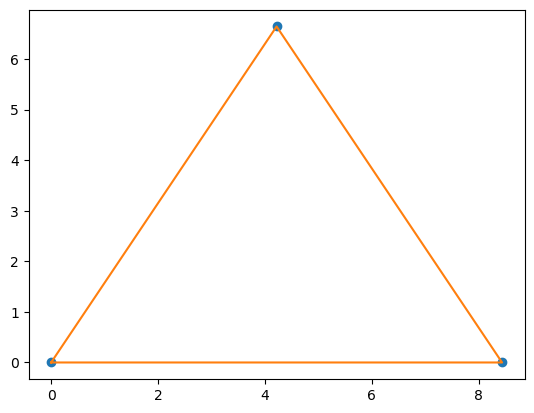

In [225]:
from scipy.spatial import ConvexHull

# 假设有一个包含点数据的 NumPy 数组
points = np.array(cell[:,:2])

# 计算凸包并获取凸包的顶点
hull = ConvexHull(points)
vertices = hull.vertices

# 按照逆时针方向连接凸包的顶点
polygon = points[vertices, :]
polygon = np.vstack((polygon, polygon[0, :]))

# 绘制出凸包
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(polygon[:, 0], polygon[:, 1])
plt.show()


In [205]:

print(top)


[[0.         0.         4.01148615]
 [2.81270711 0.         4.01148615]
 [5.62541422 0.         4.01148615]
 [1.40635355 2.21443255 4.01148615]
 [4.21906066 2.21443255 4.01148615]
 [7.03176777 2.21443255 4.01148615]
 [2.81270711 4.42886511 4.01148615]
 [5.62541422 4.42886511 4.01148615]
 [8.43812132 4.42886511 4.01148615]]


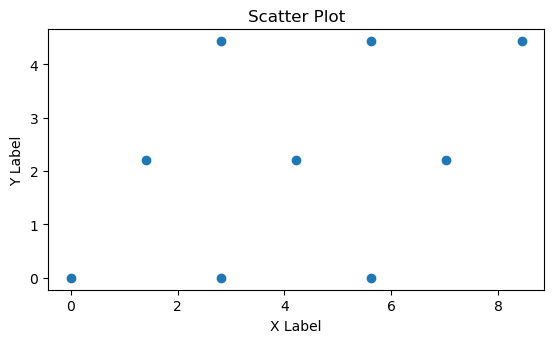

In [206]:

# 生成随机数据
x = top[:,0]
y = top[:,1]

# 创建画布和子图
fig, ax = plt.subplots()

# 绘制散点图
ax.scatter(x, y)

# 设置坐标轴标签和标题
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_title('Scatter Plot')
ax.set_aspect('equal')
# 显示图形
plt.show()


In [211]:
# 定义基矩阵 B 和待求矢量 v
B = np.array([[2, 0, 0], [0, 1, 0], [0, 0, 1]])
v = np.array([2, 0, 0])

# 求解 v 在基矢量构成的坐标系中的相对坐标
coords = np.linalg.solve(B, v)

print('v 在基矢量构成的坐标系中的相对坐标为：', coords)

v 在基矢量构成的坐标系中的相对坐标为： [1. 0. 0.]


In [124]:
# 施加应变
strain_bulk = bulk.copy()
# 获取当前的晶格矩阵, 复制初始无应变构型
cell = strain_bulk.get_cell()
nostrain = np.identity(3)
# 在 x 方向上添加应变
strain = [0.1, 0, 0]
strains = nostrain + np.array([[strain[0], strain[2], 0 ],
                               [strain[2], strain[1], 0],
                               [0, 0, 0]])
newcell = np.array(cell) @ strains  #此处为矩阵相乘
# 将新的晶格矩阵赋值给 原始 Cu 对象 
strain_bulk.set_cell(newcell, scale_atoms=True)  # scale_Atoms=True must be set to True to ensure that ...
# ...the atomic coordinates adapt to changes in the lattice matrix
strain = cal_strain(model,strain_bulk)
print(strain_bulk.get_cell)
# 施加应变后的模型，lammps可读文件
write('strain.lmp', strain_bulk, format='lammps-data')

strain:  [0.10187494 0.00170449 0.00170449]
<bound method Atoms.get_cell of Atoms(symbols='Cu27', pbc=True, cell=[[8.438121322723608, 0.0, 0.0], [4.219060661361802, 6.6432976597216395, 0.0], [0.0, 0.0, 6.263361099506486]], tags=...)>


In [125]:
infile = 'in.strain.in'
lmp = lammps()
lmp.file(infile)

LAMMPS (28 Mar 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Total wall time: 0:00:00
Reading data file ...
  triclinic box = (0 0 0) to (8.4381213 6.6432977 6.2633611) with tilt (4.2190607 0 0)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  27 atoms
  read_data CPU = 0.000 seconds
Reading eam/alloy potential file Cu_zhou.eam.alloy with DATE: 2007-10-12
Switching to 'neigh_modify every 1 delay 0 check yes' setting during minimization
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11.0375
  ghost atom cutoff = 11.0375
  binsize = 5.51875, bins = 3 2 2
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up cg style mi

In [126]:
atoms = lammpsdata.read_lammps_data('opt_strain.data',style='atomic')
print(model.cell)
print(atoms.cell)
# atoms.set_pbc(True)
# strain = cal_strain(model,atoms)
bulk_strain = opt_config.copy()
# print(bulk.get_cell())
# print(atoms.get_cell())
bulk_strain.set_cell(atoms.get_cell(), scale_atoms=True)
srtain = cal_strain(bulk,bulk_strain)
# print(bulk.get_cell())

Cell([[7.65796644025031, 0.0, 0.0], [3.828983220125155, 6.6319934785854535, 0.0], [0.0, 0.0, 6.252703415323648]])
Cell([[8.438121322723608, 0.0, 0.0], [4.219060661361802, 6.6432976597216395, 0.0], [0.0, 0.0, 6.017229222999999]])
strain:  [ 0.1         0.         -0.03929709]


In [127]:
strain = [0.1, 0, 0]
strain_bulk, strain_real = opt_strain(strain,bulk)

strain:  [0.1 0.  0. ]
[0.1 0.  0. ]
LAMMPS (28 Mar 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Reading data file ...
  triclinic box = (0 0 0) to (8.4381213 6.6432977 6.2633611) with tilt (4.2190607 0 0)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  27 atoms
  read_data CPU = 0.000 seconds
Reading eam/alloy potential file Cu_zhou.eam.alloy with DATE: 2007-10-12
Switching to 'neigh_modify every 1 delay 0 check yes' setting during minimization
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11.0375
  ghost atom cutoff = 11.0375
  binsize = 5.51875, bins = 3 2 2
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up

In [ ]:
infile = 'in.strain.in'
lmp = lammps()
lmp.file(infile)

LAMMPS (28 Mar 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Total wall time: 1:59:21
Reading data file ...
  triclinic box = (0 0 0) to (7.6579664 6.6319935 6.2527034) with tilt (3.8289832 0 0)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  27 atoms
  read_data CPU = 0.003 seconds
Reading eam/alloy potential file Cu_zhou.eam.alloy with DATE: 2007-10-12
Switching to 'neigh_modify every 1 delay 0 check yes' setting during minimization
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11.0375
  ghost atom cutoff = 11.0375
  binsize = 5.51875, bins = 3 2 2
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up cg style mi

In [ ]:
print(opt_config.cell)
strain_model, strain_energe= set_strain(opt_config, strain=[0.1,0,0],is_opt=True)
strain = cal_strain(model,strain_model)


In [ ]:
from ase.io import read
from ase.calculators.emt import EMT
from ase.optimize import BFGS

def optimize_structure(atoms):
    # 读取初始结构信息
    # 创建势函数对象
    calc = EMT()
    atoms.set_calculator(calc)

    # 进行 BFGS 优化
    dyn = LBFGS(atoms)
    dyn.run(fmax=0, steps=100)

    # 打印优化前后的晶格参数
    print('Initial cell parameters: ', atoms.cell)
    print('Final cell parameters: ', atoms.get_cell())

    # 返回优化后的结构信息
    return atoms

# 调用函数进行结构优化
optimized_structure = optimize_structure(strain_model)


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 13:47:01        1.780340*       0.0000
LBFGS:    1 13:47:01        1.780340*       0.0000
LBFGS:    2 13:47:01       94.770000*       0.0000
LBFGS:    3 13:47:01       94.770000*       0.0000
LBFGS:    4 13:47:01       94.770000*       0.0000
LBFGS:    5 13:47:01       94.770000*       0.0000
LBFGS:    6 13:47:01       94.770000*       0.0000
LBFGS:    7 13:47:01       94.770000*       0.0000
LBFGS:    8 13:47:01       94.770000*       0.0000
LBFGS:    9 13:47:01       94.770000*       0.0000
LBFGS:   10 13:47:01       94.770000*       0.0000
LBFGS:   11 13:47:02       94.770000*       0.0000
LBFGS:   12 13:47:02       94.770000*       0.0000
LBFGS:   13 13:47:02       94.770000*       0.0000
LBFGS:   14 13:47:02       94.770000*       0.0000
LBFGS:   15 13:47:02       94.770000*       0.0000
LBFGS:   16 13:47:02       94.770000*       0.0000
LBFGS:   17 13:47:02       94.7700

In [ ]:
strain_model.constraints
help(strain_model.set_cell)

Help on method set_cell in module ase.atoms:

set_cell(cell, scale_atoms=False, apply_constraint=True) method of ase.atoms.Atoms instance
    Set unit cell vectors.
    
    Parameters:
    
    cell: 3x3 matrix or length 3 or 6 vector
        Unit cell.  A 3x3 matrix (the three unit cell vectors) or
        just three numbers for an orthorhombic cell. Another option is
        6 numbers, which describes unit cell with lengths of unit cell
        vectors and with angles between them (in degrees), in following
        order: [len(a), len(b), len(c), angle(b,c), angle(a,c),
        angle(a,b)].  First vector will lie in x-direction, second in
        xy-plane, and the third one in z-positive subspace.
    scale_atoms: bool
        Fix atomic positions or move atoms with the unit cell?
        Default behavior is to *not* move the atoms (scale_atoms=False).
    apply_constraint: bool
        Whether to apply constraints to the given cell.
    
    Examples:
    
    Two equivalent ways t

In [ ]:
strain_bulk = opt_config.copy()
# 获取当前的晶格矩阵, 复制初始无应变构型
strains = strain_bulk.get_cell()
# 在 x 方向上添加应变
strains[:,0] *= 1.1
# 将新的晶格矩阵赋值给 原始 Cu 对象 
strain_bulk.set_cell(strains, scale_atoms=True)  # scale_Atoms=True must be set to True to ensure that ...
# ...the atomic coordinates adapt to changes in the lattice matrix
strain = cal_strain(model,strain_bulk)
print(strain_bulk.get_cell)

strain:  [0.1 0.  0. ]
<bound method Atoms.get_cell of Atoms(symbols='Cu27', pbc=True, cell=[[8.423763084275341, 0.0, 0.0], [4.211881542137671, 6.6319934785854535, 0.0], [0.0, 0.0, 6.252703415323648]], tags=...)>


In [ ]:
# 创建一个 FixCartesian 约束对象，冻结 x、y 和 z 方向上的自由度
FixCartesian(strain_bulk, mask=[True, True, False])
strain_bulk.set_pbc(True)
strain_bulk.set_calculator(EMT()) # setting the calculated potential 

In [ ]:
strain_bulk.set_calculator(EMT()) # setting the calculated potential 
# 创建 LBFGS 实例
dyn = LBFGS(strain_bulk)
# 进行能量最小化优化计算
dyn.run(fmax=1E-8, steps=100)

# 输出优化后的结构信息和能量值
opt_config = dyn.atoms # initial model
opt_energy = dyn.atoms.get_potential_energy()
strain = cal_strain(model,opt_config)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 13:47:04        1.780340*       0.0000
strain:  [0.1 0.  0. ]


In [ ]:
if __name__ == '__main__':
    # 这里是你要执行的代码
    print('start')

start
